In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the images
])

# Load the MNIST dataset
train_all = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_data, val_data = torch.utils.data.random_split(train_all, [50000, 10000], torch.Generator().manual_seed(0))
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 43311777.21it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30535844.17it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 10646499.26it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3845484.21it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



1. (30’) build a 10-class softmax classifier on the images. Train the classifier via storchastic gradient
descent, and report test accuracy.

In [2]:
# Step 2: Build the Classifier
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

# Train the Classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

train_model(model, train_loader, criterion, optimizer)

# Evaluate the Classifier
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on test set: {100 * correct / total}%")

evaluate_model(model, test_loader)

Epoch 1, Loss: 0.3768849743868384
Epoch 2, Loss: 0.1794211362057444
Epoch 3, Loss: 0.12779515269129058
Epoch 4, Loss: 0.09927766081993766
Epoch 5, Loss: 0.08347399573287238
Epoch 6, Loss: 0.069737104135101
Epoch 7, Loss: 0.06053912126378197
Epoch 8, Loss: 0.05252183922935668
Epoch 9, Loss: 0.045004833255634855
Epoch 10, Loss: 0.04052921248834504
Accuracy on test set: 97.5%


2. (40’) Insert one hidden layer with 1024 hidden units before the softmax classifier. And use ReLU as
the activation function at the hidden layer. Train and report test accuracy

In [3]:
# Update the Classifier with a hidden layer of 1024 units
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

train_model(model, train_loader, criterion, optimizer)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on test set: {100 * correct / total}%")

evaluate_model(model, test_loader)


Epoch 1, Loss: 0.3636392440904132
Epoch 2, Loss: 0.1705639328035857
Epoch 3, Loss: 0.12332437179334786
Epoch 4, Loss: 0.09416401952557514
Epoch 5, Loss: 0.07795981683618272
Epoch 6, Loss: 0.06573279220592992
Epoch 7, Loss: 0.05367608157122303
Epoch 8, Loss: 0.04670961163944
Epoch 9, Loss: 0.04004100139599408
Epoch 10, Loss: 0.03333943870717712
Accuracy on test set: 97.94%


3. Now, instead of inserting one hidden layer, we insert L(L ≥ 2) hidden layers, each with equal number
of hidden units. We keep the total learnable parameters at 814, 090. Derive the number of hidden
units per layer. Express it as a function of L

In [4]:
from sympy import symbols, solve

H, L = symbols('H L')
equation = H**2 * (L - 1) + H * (794 + L) + 10 - 814090

# Solve for H in terms of L
solution = solve(equation, H)
solution


[(-L - sqrt(L**2 + 3257908*L - 2625884) - 794)/(2*(L - 1)),
 (-L + sqrt(L**2 + 3257908*L - 2625884) - 794)/(2*(L - 1))]

4. (bonus 50’) Train a MLP model with architecture defined in problem 3, where L = 2, 3, . . . , 8. Get
test accuracy for each L. Note that in problem 2, we already get the accuracy when L = 1. Plot the
accuracy against L, where L = 1, 2, 3, . . . , 8

L = 1, Hidden Units = 814, Accuracy = 97.18%
L = 2, Hidden Units = 588, Accuracy = 97.26%
L = 3, Hidden Units = 469, Accuracy = 97.1%
L = 4, Hidden Units = 404, Accuracy = 97.04%
L = 5, Hidden Units = 362, Accuracy = 97.21%
L = 6, Hidden Units = 331, Accuracy = 95.88%
L = 7, Hidden Units = 307, Accuracy = 96.13%
L = 8, Hidden Units = 288, Accuracy = 95.53%


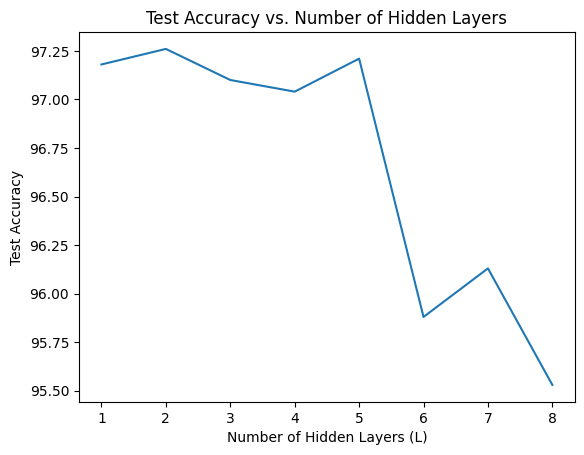

In [5]:
import matplotlib.pyplot as plt
from math import sqrt

# Function to calculate the number of hidden units
def calculate_hidden_units(L):
    if L == 1:
        return 814
    return int((-L + sqrt(L**2 + 3257908*L - 2625884) - 794) / (2 * (L - 1)))

# Define the MLP model
def create_mlp_model(L, H):
    layers = [nn.Linear(28*28, H), nn.ReLU()]
    for _ in range(L - 1):
        layers.append(nn.Linear(H, H))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(H, 10))
    return nn.Sequential(*layers)

# Function to train and evaluate the model
def train_evaluate_mlp(L, H, train_loader, test_loader):
    model = create_mlp_model(L, H)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    epoches = 5

    for epoch in range(epoches):
        for data, target in train_loader:
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# Main loop for different values of L
accuracies = []
for L in range(1, 9):
    H = calculate_hidden_units(L)
    accuracy = train_evaluate_mlp(L, H, train_loader, test_loader)
    accuracies.append(accuracy)
    print(f'L = {L}, Hidden Units = {H}, Accuracy = {accuracy}%')

# Plotting
plt.plot(range(1, 9), accuracies)
plt.xlabel('Number of Hidden Layers (L)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of Hidden Layers')
plt.show()
